<a href="https://colab.research.google.com/github/SaketMunda/transfer-learning-with-tensorflow/blob/master/scaling_up_transfer_learning_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scaling Up Food Vision 101 using Transfer Learning with TensorFlow

We're going to move forward with Food Vision 101 dataset and scale up with all the classes(previously we did with 10 classes) in Food101 dataset and build a Food Vision Mini.

In [1]:
# Are we using a gpu ?
!nvidia-smi

Wed Jan  4 04:55:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Tesla T4 GPU we are using.

## Load 10% of Food101 Dataset

In the original Food101 dataset, there's 1000 images per class (750 of each class in the training set and 250 of each class in the test set), totalling 101,000 images.

We could start modelling straight away on this large dataset but in the spirit of continually experimenting, we're going to see how our previously working model's go with 10% of the training data.

This means for each of the 101 food classes we'll be building a model on 75 training images and evaluating it on 250 test images.

In [2]:
# Download the helper function
!wget https://raw.githubusercontent.com/SaketMunda/ml-helpers/master/helper_functions.py

# Import functions from helper_functions.py
from helper_functions import unzip_data, walk_through_dir, create_tensorboard_callback, plot_loss_curves

--2023-01-04 04:57:38--  https://raw.githubusercontent.com/SaketMunda/ml-helpers/master/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2904 (2.8K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   2.84K  --.-KB/s    in 0s      

2023-01-04 04:57:39 (57.1 MB/s) - ‘helper_functions.py’ saved [2904/2904]



In [3]:
# Download Zipfile of Food101 Dataset
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

# Unzip the file
unzip_data('101_food_classes_10_percent.zip')

# walking through the directory
walk_through_dir('101_food_classes_10_percent')

--2023-01-04 05:03:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  22.7MB/s    in 68s     

2023-01-04 05:04:12 (22.8 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]

There are 2 directories and 0 files in '101_food_classes_10_percent'
There are 101 directories and 0 files in '101_food_classes_10_percent/train'
There are 0 directories and 75 files in '101_food_classes_10_percent/train/club_sandwich'
There are 0 directories and 75 files in '101_food_classes_10_percent/train/gnocchi'
There are 0 directories and 75 files in '101

## Preprocess the Loaded Data (10%)

We can preprocess using `image_dataset_from_directory` function to turn our images and labels into a `tf.data.Dataset`, a tensorflow datatype which allows us to pass it directory to our model.

In [4]:
# Setup data inputs
import tensorflow as tf
IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test/'

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode='categorical',
                                                                                batch_size=BATCH_SIZE,
                                                                                image_size=IMG_SHAPE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SHAPE,
                                                                batch_size=BATCH_SIZE,
                                                                shuffle=False)# don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


It looks like our training dataset contain, 75 images per class (101 classes) and test dataset contain, 250 images per class from 101 classes.

## Train a transfer learning Model on 10% of 101 food classes

We're going to start by using feature extraction transfer learning with a pre-trained model for a few epochs and then fine-tune for a few more epochs.

Our modelling setup will be:
- A ModelCheckpoint callback to save our progress during training, this means we could experiment further training later without having to train from scratch every time.
- Data Augmentation built right into the model
- A headless(no top layers) EfficientNetB0 architecture from `tf.keras.applications` as our base model
- A `Dense` layer with 101 hidden neurons (same as the number of food classes) and softmax activation as the output layer
- Categorical Crossentropy as the loss function since we're dealing with more than two classes
- The Adam optimizer with the default settings
- Fitting for full 5 passes on the training data while evaluating 15% of the test data.


In [5]:
# Start with creating a ModelCheckpoint
checkpoint_path = '101_classes_10_percent_data_model_checkpoint'

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                              save_best_only=True, # save the best model weights on file (delete the rest)
                                                              save_weights_only=True, # save weights only
                                                              monitor='val_accuracy') # save the model weights which score the best validation accuracy

In [14]:
# data augmentation layer
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    #preprocessing.Rescaling(1/255.) keep for models like ResNet50
])

In [15]:
# Create the base_model
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # so that we can add our own output layers
base_model.trainable=False

# Setup the model architecture with trainable top layers
inputs = layers.Input(shape=IMG_SHAPE+(3,), name='input_layer') # shape of input layer
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base_model in inference mode so we can use it to extract features without updating weights
x = layers.GlobalAveragePooling2D(name='global_average_pooling')(x) # pool the outputs of the basemodel and learn only the important features
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 2s 0us/step


Model is created, let's inspect it.

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_____________________________________________

Our functional model has 5 layers but each of those layers have varying amounts of layers within them.

Time to compile and fit.

In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

# fit the model
initial_epoch = 5

history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=initial_epoch,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[modelcheckpoint_callback])

Epoch 1/5
237/237 [==============================] - 102s 371ms/step - loss: 3.3876 - accuracy: 0.2679 - val_loss: 2.5558 - val_accuracy: 0.4227
Epoch 2/5
237/237 [==============================] - 65s 272ms/step - loss: 2.2167 - accuracy: 0.4869 - val_loss: 2.0334 - val_accuracy: 0.5159
Epoch 3/5
237/237 [==============================] - 61s 257ms/step - loss: 1.8433 - accuracy: 0.5607 - val_loss: 1.8813 - val_accuracy: 0.5334
Epoch 4/5
237/237 [==============================] - 57s 241ms/step - loss: 1.6393 - accuracy: 0.6005 - val_loss: 1.8008 - val_accuracy: 0.5373
Epoch 5/5
237/237 [==============================] - 53s 224ms/step - loss: 1.4772 - accuracy: 0.6397 - val_loss: 1.7444 - val_accuracy: 0.5469


Evaluate the model on full test dataset

In [18]:
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 58s 73ms/step - loss: 1.5785 - accuracy: 0.5851


[1.5784589052200317, 0.5851089358329773]

Well it looks like **we just beat our baseline (the results from the original Food101 paper) with 10% of the data** In under 5-minutes... that's the power of deep learning and more precisely transfer learning: leveraging what one model has learned on another dataset for our own dataset.

How do the loss curves looks like ?

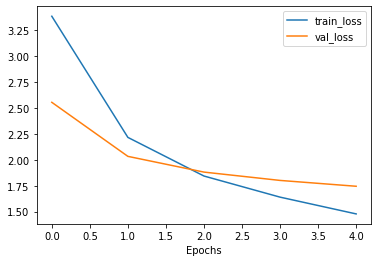

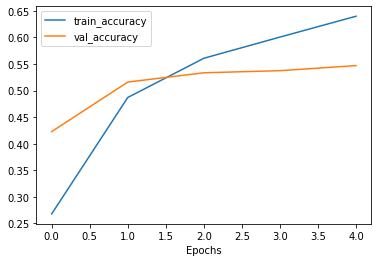

In [19]:
plot_loss_curves(history_all_classes_10_percent)

## Fine-Tuning